In [1]:
import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DB = 'chinook.db'

def run_query(query):
    with sqlite3.connect(DB) as conn:
        query_result = pd.read_sql(query, conn)
        
        return query_result
    
def run_command(cmd):
    with sqlite3.connect(DB) as conn:
        conn.isolation_level = None
        conn.execute(cmd)
        
def show_tables():
    query = '''SELECT
                   name
                   , type
               FROM sqlite_master
               WHERE type IN ("table", "view");'''
    return run_query(query)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [4]:
query_genre = '''
WITH
genre_tracks_usa AS
    (
     SELECT
         g.name AS genre
         , i.billing_country
         , il.invoice_line_id track_sold
     FROM invoice AS i
         INNER JOIN invoice_line AS il 
             ON il.invoice_id = i.invoice_id
         INNER JOIN track AS t 
             ON t.track_id = il.track_id
         INNER JOIN genre AS g
             ON g.genre_id = t.genre_id
     WHERE i.billing_country = "USA"
    )      

SELECT
    genre
    , COUNT(track_sold) AS tracks_sold_usa
    , CAST(COUNT(track_sold) AS FLOAT) / 
        (
         SELECT
             COUNT(track_sold)
         FROM genre_tracks_usa
         GROUP BY billing_country
        ) AS percentage
FROM genre_tracks_usa
GROUP BY genre;
'''
tracks_sold_usa = run_query(query_genre)
tracks_sold_usa.set_index('genre', inplace=True)
print(tracks_sold_usa)

                    tracks_sold_usa  percentage
genre                                          
Alternative                      35    0.033302
Alternative & Punk              130    0.123692
Blues                            36    0.034253
Classical                         4    0.003806
Easy Listening                   13    0.012369
Electronica/Dance                 5    0.004757
Heavy Metal                       3    0.002854
Hip Hop/Rap                      20    0.019029
Jazz                             14    0.013321
Latin                            22    0.020932
Metal                           124    0.117983
Pop                              22    0.020932
R&B/Soul                         53    0.050428
Reggae                            6    0.005709
Rock                            561    0.533777
Soundtrack                        2    0.001903
TV Shows                          1    0.000951


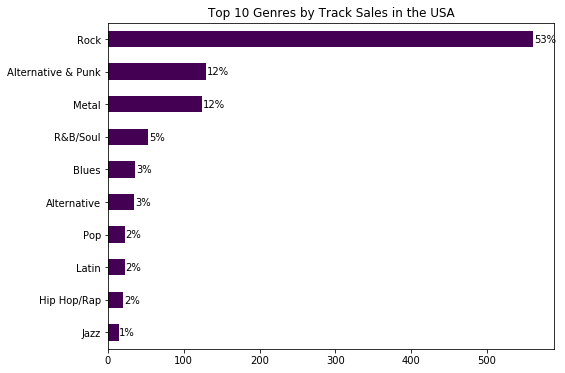

In [5]:
plt.figure(figsize=(8, 6))

top_10_genres = tracks_sold_usa.sort_values('percentage').tail(10)
top_10_genres['tracks_sold_usa'].plot(
    kind='barh',
    title='Top 10 Genres by Track Sales in the USA',
    cmap=plt.cm.viridis)
plt.ylabel('')

for i, index in enumerate(top_10_genres.index):
    fs = '{:.0f}%'
    count = top_10_genres.loc[index, 'tracks_sold_usa']
    pct = top_10_genres.loc[index, 'percentage'] * 100
    plt.annotate(fs.format(pct), (count+1, i-.1))
plt.show()

In [14]:
# Query that finds total dollar amount of sales assigned to each
# support agent within the company
query_sales = '''
SELECT
    e.first_name || " " || e.last_name AS name
    , SUM(i.total) AS total
FROM invoice AS i
    INNER JOIN customer AS c
        ON c.customer_id = i.customer_id
    INNER JOIN employee AS e
        ON e.employee_id = c.support_rep_id
WHERE e.title = "Sales Support Agent"
GROUP BY employee_id
'''

support_agent_total_sales = run_query(query_sales)
support_agent_total_sales.set_index('name', inplace=True)
support_agent_total_sales

,total
name,
Jane Peacock,1731.51
Margaret Park,1584.00
Steve Johnson,1393.92


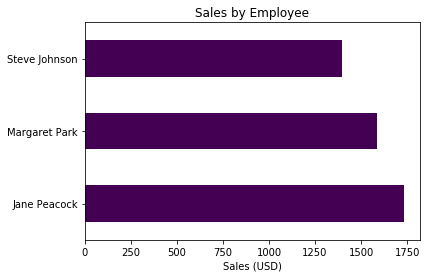

In [7]:
support_agent_total_sales.plot.barh(
    title="Sales by Employee",
    legend=False,
    cmap=plt.cm.viridis)
plt.ylabel('')
plt.xlabel('Sales (USD)')
plt.show()

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

In [13]:
country_query = '''
WITH country_or_other AS
    (
     SELECT
         CASE
             WHEN (
                   SELECT COUNT(*)
                   FROM customer
                   WHERE country = c.country
                  ) = 1 THEN "Other"
             ELSE c.country
         END AS country
         , c.customer_id
         , il.*
     FROM invoice_line AS il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country
    , customers
    , total_sales
    , average_order
    , average_customer_lifetime_value
FROM
    (
     SELECT
         country
         , COUNT(DISTINCT customer_id) customers
         , SUM(unit_price) total_sales
         , SUM(unit_price) / COUNT(DISTINCT customer_id) average_customer_lifetime_value
         , SUM(unit_price) / COUNT(DISTINCT invoice_id) average_order
         , CASE
             WHEN country == "Other" THEN 1
             ELSE 0
         END AS sort
     FROM country_or_other
     GROUP BY country
     ORDER BY sort ASC, total_sales DESC
    );
'''

sales_by_country = run_query(country_query)
sales_by_country.set_index('country', inplace=True)
sales_by_country

,country,customers,total_sales,average_order,average_customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


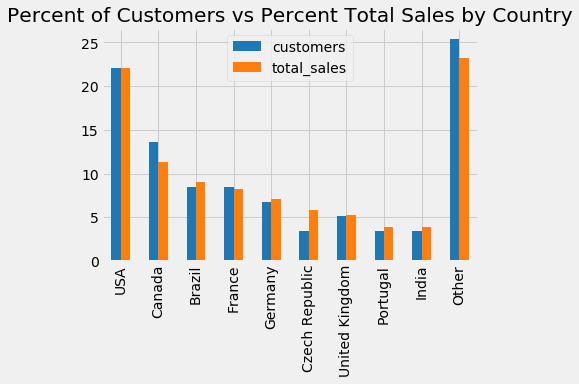

In [63]:
plt.style.use('fivethirtyeight')
colors = [plt.cm.tab10(i) for i in np.linspace(0, 1, sales_by_country.shape[0])]
sales_customers = sales_by_country[['customers', 'total_sales']]
pct_sales_customers = sales_customers / sales_customers.sum() * 100

pct_sales_customers.plot.bar(
    title='Percent of Customers vs Percent Total Sales by Country',
    color=colors)
plt.xlabel('')
plt.show()